In [14]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, GRU, concatenate
)

In [15]:
# =================================================================
# 1. 데이터 로딩 및 전처리 함수
# =================================================================

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    data_path = prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/'
    trainX, trainy = load_dataset_group('train', data_path)
    testX, testy = load_dataset_group('test', data_path)

    # 라벨을 0부터 시작하도록 수정
    trainy = trainy - 1
    testy = testy - 1

    # 원-핫 인코딩
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(f"Data Shapes: TrainX{trainX.shape}, Trainy_oh{trainy_one_hot.shape}, TestX{testX.shape}, Testy_oh{testy_one_hot.shape}")
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [16]:
# =================================================================
# 2. 데이터 로드 및 스케일링
# =================================================================

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(prefix='')

# 훈련 데이터 → 훈련/검증 분할 (80:20)
trainX_split, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

# 시계열 데이터 크기 정보
n_timesteps = trainX_split.shape[1]
n_features = trainX_split.shape[2]

# ⭐️ StandardScaler 적용 ⭐️
X_train_reshaped = trainX_split.reshape(-1, n_features)
scaler = StandardScaler()
scaler.fit(X_train_reshaped)

# 모든 데이터셋에 스케일링 적용
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val.reshape(-1, n_features))
X_test_scaled_reshaped = scaler.transform(testX.reshape(-1, n_features))

# 원래 형태로 복원
X_train = X_train_scaled_reshaped.reshape(-1, n_timesteps, n_features)
X_val = X_val_scaled_reshaped.reshape(-1, n_timesteps, n_features)
testX = X_test_scaled_reshaped.reshape(-1, n_timesteps, n_features)

n_outputs = y_train_one_hot.shape[1]

print(f"\nScaling Applied. New X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, TestX shape: {testX.shape}")

/tmp/ipython-input-4210248212.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4210248212.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4210248212.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4210248212.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


Data Shapes: TrainX(7352, 128, 9), Trainy_oh(7352, 6), TestX(2947, 128, 9), Testy_oh(2947, 6)

Scaling Applied. New X_train shape: (5881, 128, 9), X_val shape: (1471, 128, 9), TestX shape: (2947, 128, 9)


In [17]:
# =================================================================
# 3. 공통 시각화 및 평가 함수
# =================================================================

def plot_history(history, model_name):
    """훈련 손실 및 정확도 시각화"""
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'y', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.title(f'{model_name}: Training and Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'y', label='Training acc')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation acc')
    plt.title(f'{model_name}: Training and Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
    plt.show()

def evaluate_and_report(model, X_test, y_test, y_test_one_hot, model_name, is_multi_input=False):
    """테스트 데이터 평가 및 혼동 행렬 출력"""
    X_test_input = [X_test, X_test, X_test, X_test] if is_multi_input else X_test
    loss, acc = model.evaluate(X_test_input, y_test_one_hot, verbose=0)
    pred = model.predict(X_test_input)
    pred_classes = np.argmax(pred, axis=-1)

    print(f"\n--- {model_name} Test Performance ---")
    print(f"Test Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, pred_classes, zero_division=0))

    cm = confusion_matrix(y_test, pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label'); plt.xlabel('Predicted Label')
    plt.show()



4. 🎛️ 모델 1: 다중 스케일 CNN (Multi-Scale CNN)
Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.7559 - loss: 0.6961 - val_accuracy: 0.9542 - val_loss: 0.1048
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - accuracy: 0.9537 - loss: 0.1088 - val_accuracy: 0.9508 - val_loss: 0.1351
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 240ms/step - accuracy: 0.9547 - loss: 0.1016 - val_accuracy: 0.9610 - val_loss: 0.1026
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.9627 - loss: 0.0815 - val_accuracy: 0.9593 - val_loss: 0.0793
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.9715 - loss: 0.0688 - val_accuracy: 0.9576 - val_loss: 0.1007
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.9556 - loss: 0.0991 - val_accuracy: 0.9576 - val_loss: 0.0835
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9701 - loss: 0.0801 - val_accuracy: 0.9677 - val_loss: 0.0680
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2

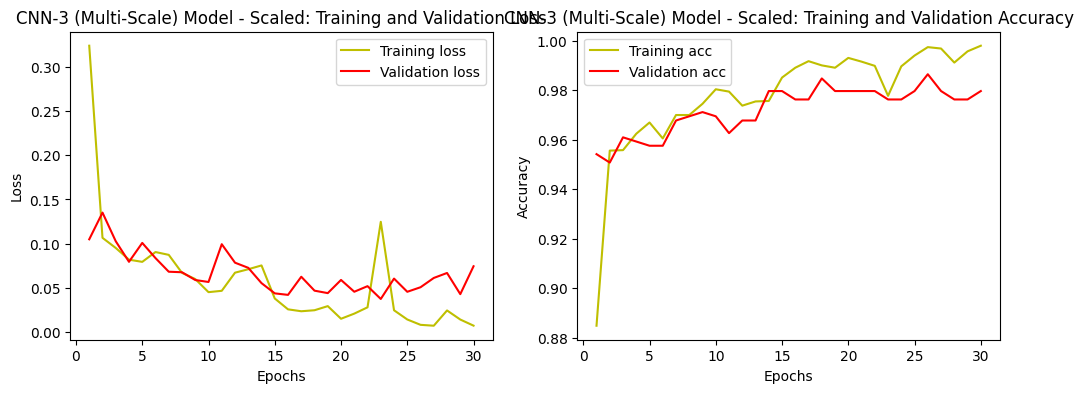

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step

--- CNN-3 (Multi-Scale) Model - Scaled Test Performance ---
Test Accuracy: 93.72%
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       496
           1       0.96      0.94      0.95       471
           2       0.95      1.00      0.97       420
           3       0.93      0.78      0.85       491
           4       0.82      0.96      0.89       532
           5       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



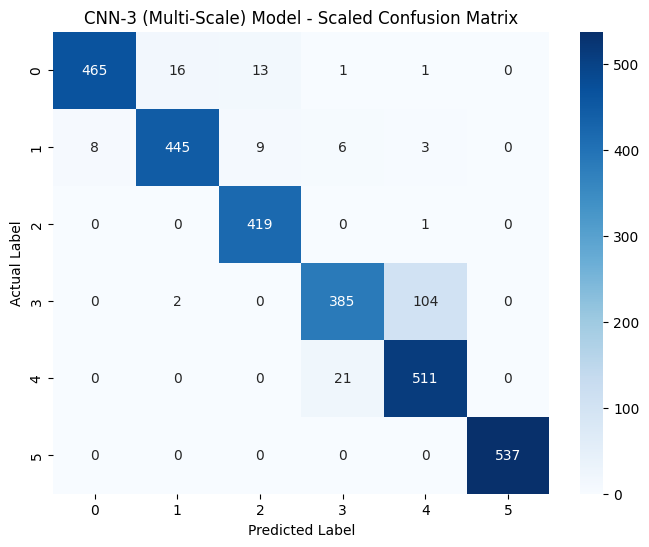

In [18]:
# =================================================================
# 4. 모델 1: 다중 스케일 CNN (Multi-Scale CNN)
# =================================================================
print("\n" + "="*60)
print("4. 🎛️ 모델 1: 다중 스케일 CNN (Multi-Scale CNN)")
print("="*60)

inputs1_1= Input(shape=(n_timesteps,n_features))
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1)
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)

merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)
pool_1=MaxPooling1D(pool_size=5)(merged_1)

conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)
pool_2=MaxPooling1D(pool_size=5)(merged_2)

conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)
pool_3=MaxPooling1D(pool_size=5)(merged_3)

flat_cnn=Flatten()(pool_3)
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

cnn3_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)
cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn3_history=cnn3_model.fit(
    x=[X_train,X_train,X_train,X_train], y=y_train_one_hot,
    epochs=30, batch_size=32, validation_split=0.1, verbose=1
)

plot_history(cnn3_history, "CNN-3 (Multi-Scale) Model - Scaled")
evaluate_and_report(cnn3_model, testX, testy, testy_one_hot, "CNN-3 (Multi-Scale) Model - Scaled", is_multi_input=True)



5. 🧠 모델 2: LSTM
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.5621 - loss: 1.1248 - val_accuracy: 0.8980 - val_loss: 0.3049
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9094 - loss: 0.2593 - val_accuracy: 0.9477 - val_loss: 0.1556
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9372 - loss: 0.1670 - val_accuracy: 0.9504 - val_loss: 0.1275
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9468 - loss: 0.1621 - val_accuracy: 0.9347 - val_loss: 0.1419
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9411 - loss: 0.1431 - val_accuracy: 0.9415 - val_loss: 0.1453
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9501 - loss: 0.1252 - val_accuracy: 0.9504 - val_loss: 0.1312
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9426 - loss: 0.1294 - val_accuracy: 0.9443 - val_loss: 0.1203
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9555 - loss: 0.1151 - val_accurac

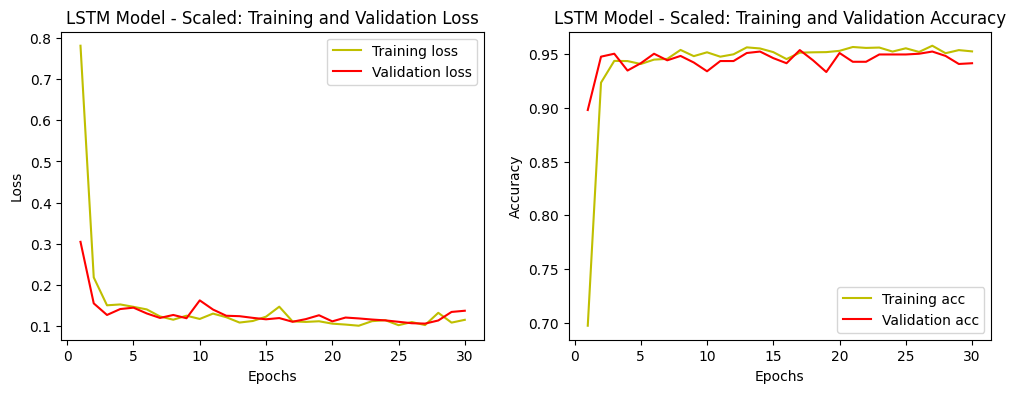

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

--- LSTM Model - Scaled Test Performance ---
Test Accuracy: 91.41%
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       496
           1       0.98      0.92      0.95       471
           2       0.89      0.99      0.94       420
           3       0.86      0.74      0.79       491
           4       0.79      0.90      0.84       532
           5       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.92      0.91      0.91      2947



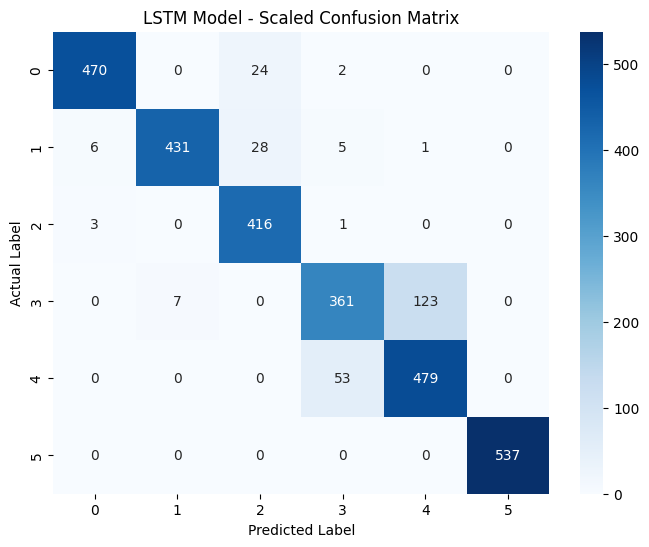

In [19]:
# =================================================================
# 5. 모델 2: LSTM
# =================================================================
print("\n" + "="*60)
print("5. 🧠 모델 2: LSTM")
print("="*60)

def create_lstm_model(n_timesteps, n_features, n_outputs):
    model = Sequential([
        LSTM(100, input_shape=(n_timesteps, n_features)),
        Dropout(0.5),
        Dense(100, activation='relu'),
        Dense(n_outputs, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model(n_timesteps, n_features, n_outputs)
lstm_history = lstm_model.fit(
    X_train, y_train_one_hot,
    epochs=30, batch_size=32, validation_data=(X_val, y_val_one_hot), verbose=1
)

plot_history(lstm_history, "LSTM Model - Scaled")
evaluate_and_report(lstm_model, testX, testy, testy_one_hot, "LSTM Model - Scaled")



6. 🧠 모델 3: GRU
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.5297 - loss: 1.1869 - val_accuracy: 0.8946 - val_loss: 0.2935
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.8778 - loss: 0.3070 - val_accuracy: 0.8409 - val_loss: 0.4080
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.9259 - loss: 0.1916 - val_accuracy: 0.9320 - val_loss: 0.1587
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.9455 - loss: 0.1377 - val_accuracy: 0.9402 - val_loss: 0.1342
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.9502 - loss: 0.1260 - val_accuracy: 0.9354 - val_loss: 0.1330
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.9503 - loss: 0.1209 - val_accuracy: 0.9354 - val_loss: 0.1339
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.9424 - loss: 0.1352 - val_accuracy: 0.9415 - val_loss: 0.1279
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.9517 - loss: 0.1186 - val_ac

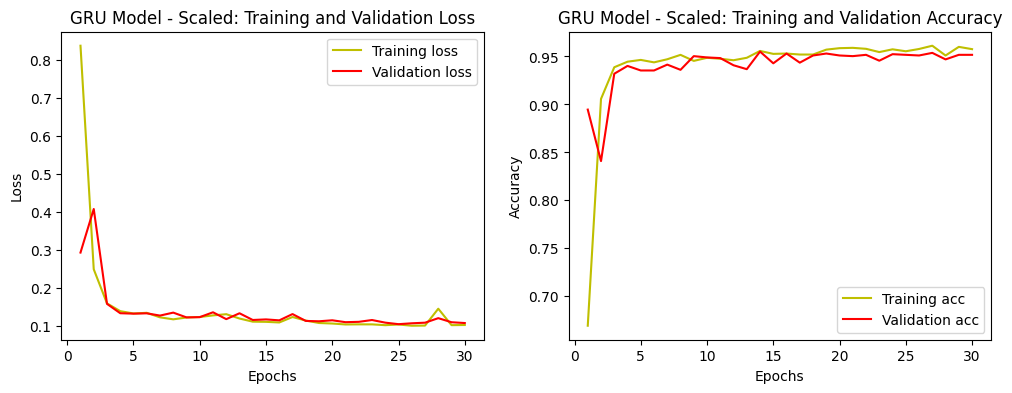

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

--- GRU Model - Scaled Test Performance ---
Test Accuracy: 91.69%
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       496
           1       0.95      0.95      0.95       471
           2       0.92      0.93      0.93       420
           3       0.82      0.81      0.81       491
           4       0.83      0.83      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



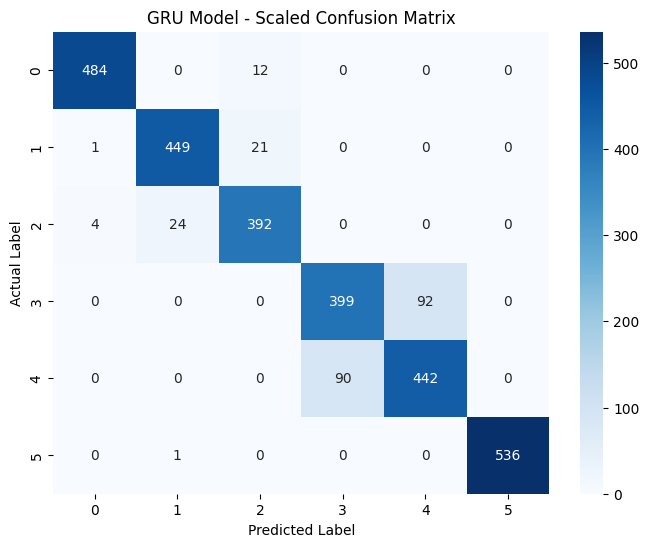

In [20]:
# =================================================================
# 6. 모델 3: GRU
# =================================================================
print("\n" + "="*60)
print("6. 🧠 모델 3: GRU")
print("="*60)

def create_gru_model(n_timesteps, n_features, n_outputs):
    model = Sequential([
        GRU(100, input_shape=(n_timesteps, n_features)),
        Dropout(0.5),
        Dense(100, activation='relu'),
        Dense(n_outputs, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

gru_model = create_gru_model(n_timesteps, n_features, n_outputs)
gru_history = gru_model.fit(
    X_train, y_train_one_hot,
    epochs=30, batch_size=32, validation_data=(X_val, y_val_one_hot), verbose=1
)

plot_history(gru_history, "GRU Model - Scaled")
evaluate_and_report(gru_model, testX, testy, testy_one_hot, "GRU Model - Scaled")



7. 🔀 모델 4: CNN-LSTM 하이브리드
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.7302 - loss: 0.6768 - val_accuracy: 0.8613 - val_loss: 0.3567
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9406 - loss: 0.1429 - val_accuracy: 0.9429 - val_loss: 0.1484
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9501 - loss: 0.1237 - val_accuracy: 0.9279 - val_loss: 0.1565
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9510 - loss: 0.1116 - val_accuracy: 0.9477 - val_loss: 0.1301
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9527 - loss: 0.1104 - val_accuracy: 0.9381 - val_loss: 0.1163
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9487 - loss: 0.1062 - val_accuracy: 0.9191 - val_loss: 0.2412
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9525 - loss: 0.1110 - val_accuracy: 0.9443 - val_loss: 0.1380
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9595 - loss: 0.0934 - val_accuracy: 0

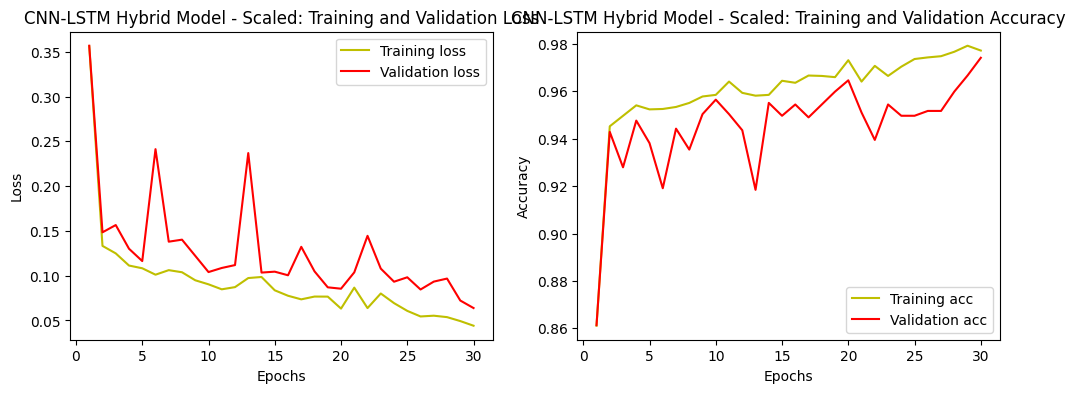

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

--- CNN-LSTM Hybrid Model - Scaled Test Performance ---
Test Accuracy: 91.72%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       496
           1       0.99      0.89      0.94       471
           2       0.94      1.00      0.97       420
           3       0.81      0.80      0.81       491
           4       0.82      0.83      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



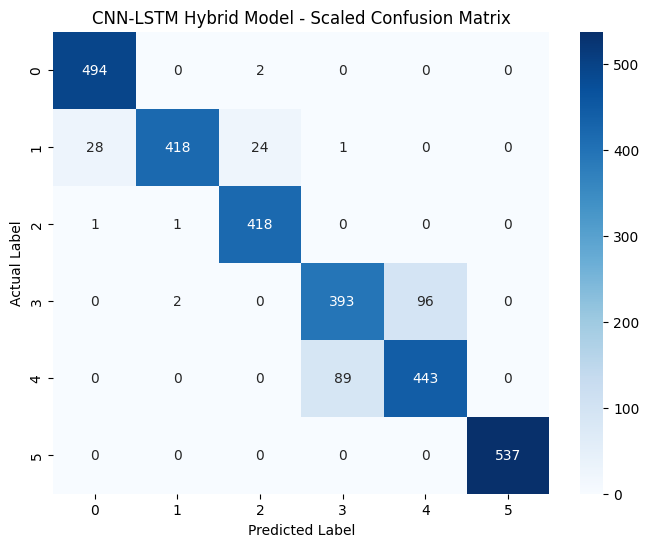

In [21]:
# =================================================================
# 7. 모델 4: CNN-LSTM 하이브리드
# =================================================================
print("\n" + "="*60)
print("7. 🔀 모델 4: CNN-LSTM 하이브리드")
print("="*60)

def create_cnn_lstm_model(n_timesteps, n_features, n_outputs):
    model = Sequential([
        Conv1D(64, kernel_size=5, activation='relu', input_shape=(n_timesteps, n_features)),
        Conv1D(64, kernel_size=5, activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=4),
        LSTM(100),
        Dense(100, activation='relu'),
        Dense(n_outputs, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_lstm_model = create_cnn_lstm_model(n_timesteps, n_features, n_outputs)
cnn_lstm_history = cnn_lstm_model.fit(
    X_train, y_train_one_hot,
    epochs=30, batch_size=32, validation_data=(X_val, y_val_one_hot), verbose=1
)

plot_history(cnn_lstm_history, "CNN-LSTM Hybrid Model - Scaled")
evaluate_and_report(cnn_lstm_model, testX, testy, testy_one_hot, "CNN-LSTM Hybrid Model - Scaled")
